In [6]:
import os
import csv
import pandas as pd
from statistics import median, mean
import numpy as np
import scipy.stats as st
from sentiment import calc_accuracy
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image
from lang_codes import lang_codes

# Reading Data
Reads the output files of bootstrap.py and saves it to a dictionary `data`.

### Sentiment Analysis Task

In [2]:
def read_sentiment_data(dir_name: str):
    data = {
        "Pipeline 1": {},
        "Pipeline 2": {},
        "Pipeline 3": {},
    }

    # Go through each pipeline
    for pline in sorted(os.listdir(dir_name)):
        if pline == "Twitter Dataset" or pline == "NewLanguages":
            pipeline = "Pipeline 1"
        elif pline == "TranslatedToEnglishTweets":
            pipeline = "Pipeline 2"
        else:
            pipeline = "Pipeline 3"

        pipeline_dir_name = dir_name + "/" + pline

        # Go through each subset (with and without neutrals)
        for subset in sorted(os.listdir(pipeline_dir_name)):  # subset is AllTweets or NoNeuTweets
            data[pipeline][subset] = {}

            subset_dir_name = pipeline_dir_name + "/" + subset

            # Go through each language
            for lang_file in sorted(os.listdir(subset_dir_name)):    
                # Open the file and convert the data to a list
                with open(subset_dir_name + "/" + lang_file) as lang:
                    reader = csv.reader(lang)
                    vals = next(reader)

                accuracies = [float(x) for x in vals]

                median_ = median(accuracies)
                mean_ = mean(accuracies)
                conf99 = st.t.interval(0.99, len(accuracies)-1, loc=np.median(accuracies), scale=st.sem(accuracies))

                stats = { 
                    "Median": median_,
                    "Mean": mean_,
                    "99 Confidence": conf99,
                    "99 Distance": abs(median_ - conf99[0])  # Error distance
                }

                cur_lang = lang_file.split(".")[0]
                data[pipeline][subset][cur_lang] = stats
                
    return data

In [3]:
# Original 15 languages
sent_data = read_sentiment_data("BootstrappedSentiment")
# New 3 langauges (Arabic, Chinese, Hindi)
sent_data_newlang = read_sentiment_data("BootstrappedSentiment_NewLanguages")

### Topic Clustering Task

In [7]:
def read_cluster_data(dir_name: str, cluster_pipe1: str, cluster_pipe3: str) -> None:
    data = {}

    for rf in sorted(os.listdir(dir_name)):
        df = pd.read_csv(dir_name + "/" + rf)
        
        language = rf.split(".")[0]
        data[language] = {}
        
        # Get the actual accuracy of each language
        data[language]["Accuracy"] = accuracy_score(df[cluster_pipe1], df[cluster_pipe3])
        
        # Shuffle cluster labels for each langauge, then calc accuracy
        df["PermutationTest"] = np.random.permutation(df[cluster_pipe3])
        data[language]["Perm Test"] = accuracy_score(df[cluster_pipe1], df["PermutationTest"])
    
    return data

In [8]:
cluster_data = read_cluster_data("All Languages_EnglishToOriginal_TopicClusterOutput", "Tweet text_Clean_Cluster", "ReverseTrans_Cluster")

In [9]:
def read_k_cluster_data(dir_name: str, cluster_pipe1: str, cluster_pipe3: str) -> None:
    data = {}

    for k in os.listdir(dir_name):
        data[k] = {}
        
        accuracies = []
        
        k_dir_name = dir_name + "/" + k
        for rf in sorted(os.listdir(k_dir_name)):
            df = pd.read_csv(k_dir_name + "/" + rf)

            language = rf.split(".")[0]
            data[k][language] = {}

            # Get the actual accuracy of each language
            acc = accuracy_score(df[cluster_pipe1], df[cluster_pipe3])
            data[k][language] = acc
            accuracies.append(acc)
            
        data[k]["Average"] = mean(accuracies)

    return data

In [10]:
k_cluster_data = read_k_cluster_data("All Languages_EnglishToOriginal_kTopicClusterOutput", "Tweet text_Clean_Cluster", "ReverseTrans_Cluster")

In [11]:
k_cluster_data

{'50': {'Arabic': 0.7807,
  'Bulgarian': 0.6528666666666667,
  'Chinese': 0.2612,
  'Croatian': 0.7799333333333334,
  'German': 0.5983333333333334,
  'Hindi': 0.8614,
  'Hungarian': 0.6774,
  'Polish': 0.6739666666666667,
  'Portuguese': 0.4648333333333333,
  'Russian': 0.5426666666666666,
  'Slovak': 0.5083333333333333,
  'Slovenian': 0.3505333333333333,
  'Spanish': 0.4921,
  'Swedish': 0.4931333333333333,
  'Average': 0.5812428571428572},
 '150': {'Arabic': 0.7839,
  'Bulgarian': 0.6720666666666667,
  'Chinese': 0.2729,
  'Croatian': 0.8069666666666667,
  'German': 0.6170666666666667,
  'Hindi': 0.8571,
  'Hungarian': 0.7031333333333334,
  'Polish': 0.6714666666666667,
  'Portuguese': 0.49173333333333336,
  'Russian': 0.6050666666666666,
  'Slovak': 0.5108666666666667,
  'Slovenian': 0.4273,
  'Spanish': 0.5854333333333334,
  'Swedish': 0.4956333333333333,
  'Average': 0.6071880952380952},
 '20': {'Arabic': 0.7759,
  'Bulgarian': 0.6434,
  'Chinese': 0.3264,
  'Croatian': 0.78026666

# Figure Generation

### Figure 1

Sentiment Analysis Task

Comparison of Pipeline 1: Cleaned Original Language and Pipeline 2: Translated to English accuracies accross all languages.

In [6]:
# Distance between median and bounds of 95% confidence interval
def lower_dist(i):
    return abs(fig_data["Confidence"][i][0] - fig_data["MedianAccuracy"][i])

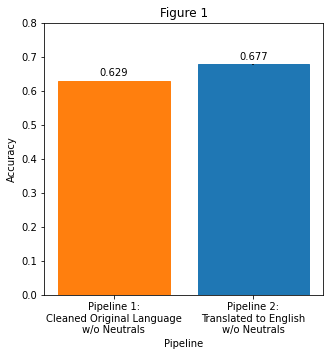

In [7]:
pl1_data = sent_data["Pipeline 1"]["NoNeuTweets"]["Combined"]
pl2_data = sent_data["Pipeline 2"]["NoNeuTweets"]["Combined"]
fig_data = pd.DataFrame({"Pipeline": ["Pipeline 1:\nCleaned Original Language\nw/o Neutrals", "Pipeline 2:\nTranslated to English\nw/o Neutrals"], 
                     "Median": [pl1_data["Median"], pl2_data["Median"]],
                     "99 Distance": [pl1_data["99 Distance"], pl2_data["99 Distance"]]})

plt.rcParams["figure.figsize"] = (5,5)

bp = sns.barplot(
    data=fig_data,
    x="Pipeline",
    y="Median",
    yerr=fig_data["99 Distance"])

plt.ylim(0, 0.8)
bp.set_title("Figure 1")
bp.set(xlabel="Pipeline", ylabel="Accuracy")

bp.patches[0].set_color("tab:orange")
bp.patches[1].set_color("tab:blue")

for bar in bp.patches:
    bp.annotate(format(bar.get_height(), '.3f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.savefig("Figures/figure1.png", bbox_inches="tight")

### Figure 2

Sentiment Analysis Task

Comparison of Pipeline 1: Cleaned Original Language and Pipeline 3: Translated Back to Original Language accuracies accross all languages.

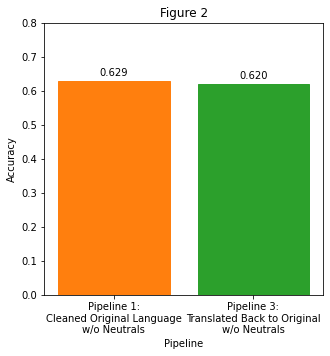

In [8]:
pl1_data = sent_data["Pipeline 1"]["NoNeuTweets"]["Combined"]
pl3_data = sent_data["Pipeline 3"]["NoNeuTweets"]["Combined"]
fig_data = pd.DataFrame({"Pipeline": ["Pipeline 1:\nCleaned Original Language\nw/o Neutrals", "Pipeline 3:\nTranslated Back to Original\nw/o Neutrals"], 
                     "Median": [pl1_data["Median"], pl3_data["Median"]],
                     "99 Distance": [pl1_data["99 Distance"], pl3_data["99 Distance"]]})

plt.rcParams["figure.figsize"] = (5,5)

bp = sns.barplot(
    data=fig_data,
    x="Pipeline",
    y="Median",
    yerr=fig_data["99 Distance"])

plt.ylim(0, 0.8)
bp.set_title("Figure 2")
bp.set(xlabel="Pipeline", ylabel="Accuracy")

bp.patches[0].set_color("tab:orange")
bp.patches[1].set_color("tab:green")

for bar in bp.patches:
    bp.annotate(format(bar.get_height(), '.3f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.savefig("Figures/figure2.png", bbox_inches="tight")

### Figure 3

Sentiment Analysis Task

Comparison of all three pipelines' accuracies for each language.

In [9]:
pipelines = ["Pipeline 2:\nTranslated to English\nw/o Neutrals", "Pipeline 1:\nCleaned Original Language\nw/o Neutrals", "Pipeline 3:\nTranslated Back to Original\nw/o Neutrals"]

In [10]:
def build_fig34_data(tweet_subset: str):
    """
    tweet_subset: Either "NoNeuTweets" or "AllTweets"
                  "NoNeuTweets" for Figure 3
                  "AllTweets" for Figure 4
    """
    fig_data = { "Albanian" :   {},
                 "Bosnian" :    {},
                 "Bulgarian" :  {},
                 "Croatian" :   {},
                 "German" :     {},
                 "Hungarian" :  {},
                 "Polish" :     {},
                 "Portuguese" : {},
                 "Russian" :    {},
                 "Serbian" :    {},
                 "Slovak" :     {},
                 "Slovenian" :  {},
                 "Spanish" :    {},
                 "Swedish" :    {}  }


    for lang in fig_data:
        fig_data[lang]["Medians"] = [sent_data["Pipeline 2"][tweet_subset][lang]["Median"],
                                     sent_data["Pipeline 1"][tweet_subset][lang]["Median"],
                                     sent_data["Pipeline 3"][tweet_subset][lang]["Median"]]
        fig_data[lang]["99 Distances"] = [sent_data["Pipeline 2"][tweet_subset][lang]["99 Distance"],
                                          sent_data["Pipeline 1"][tweet_subset][lang]["99 Distance"],
                                          sent_data["Pipeline 3"][tweet_subset][lang]["99 Distance"]]

    fig_data["English"] = {
        "Medians": [0, sent_data["Pipeline 1"][tweet_subset][lang]["Median"], 0],
        "99 Distances": [0, sent_data["Pipeline 1"][tweet_subset][lang]["99 Distance"], 0]
    }
    
    return fig_data

In [11]:
def create_barchart(lang) -> None:
    bp = sns.barplot(x=pipelines, 
                     y=fig_data[lang]["Medians"],
                     yerr=fig_data[lang]["99 Distances"])

    for bar in bp.patches:
        bp.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=10, xytext=(0, 8),
                        textcoords='offset points')
    
    plt.rcParams["figure.figsize"] = (3,3)
    
    bp.patches[0].set_color("tab:blue")
    bp.patches[1].set_color("tab:orange")
    bp.patches[2].set_color("tab:green")
    
    # Hide x axis labels
    bp.set(xticklabels=[])
    
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title(lang)

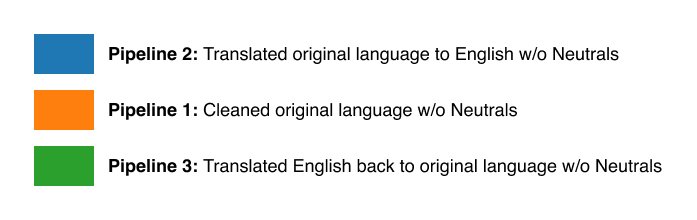

In [12]:
Image(filename="Figures/figure3-legend.png") 

In [13]:
fig_data = build_fig34_data("NoNeuTweets")

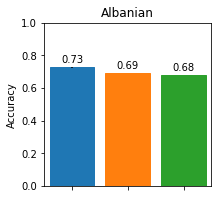

In [14]:
plt.rcParams["figure.figsize"] = (3,3)
create_barchart("Albanian")
plt.savefig("Figures/figure3-1.png", bbox_inches="tight")

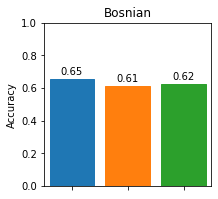

In [15]:
create_barchart("Bosnian")
plt.savefig("Figures/figure3-2.png", bbox_inches="tight")

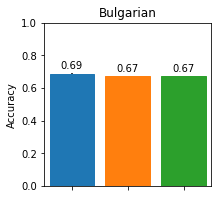

In [16]:
create_barchart("Bulgarian")
plt.savefig("Figures/figure3-3.png", bbox_inches="tight")

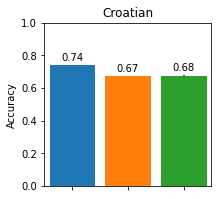

In [17]:
create_barchart("Croatian")
plt.savefig("Figures/figure3-4.png", bbox_inches="tight")

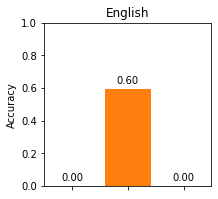

In [18]:
create_barchart("English")
plt.savefig("Figures/figure3-5.png", bbox_inches="tight")

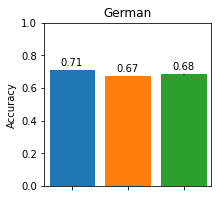

In [19]:
create_barchart("German")
plt.savefig("Figures/figure3-6.png", bbox_inches="tight")

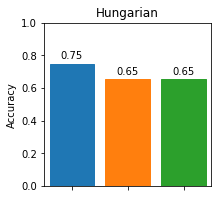

In [20]:
create_barchart("Hungarian")
plt.savefig("Figures/figure3-7.png", bbox_inches="tight")

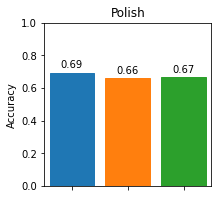

In [21]:
create_barchart("Polish")
plt.savefig("Figures/figure3-8.png", bbox_inches="tight")

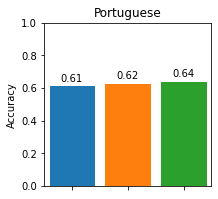

In [22]:
create_barchart("Portuguese")
plt.savefig("Figures/figure3-9.png", bbox_inches="tight")

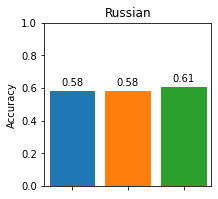

In [23]:
create_barchart("Russian")
plt.savefig("Figures/figure3-10.png", bbox_inches="tight")

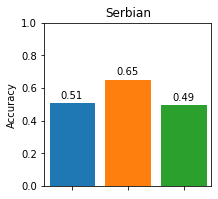

In [24]:
create_barchart("Serbian")
plt.savefig("Figures/figure3-11.png", bbox_inches="tight")

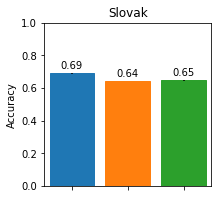

In [25]:
create_barchart("Slovak")
plt.savefig("Figures/figure3-12.png", bbox_inches="tight")

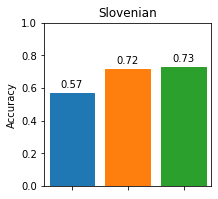

In [26]:
create_barchart("Slovenian")
plt.savefig("Figures/figure3-13.png", bbox_inches="tight")

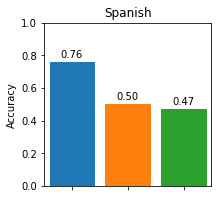

In [27]:
create_barchart("Spanish")
plt.savefig("Figures/figure3-14.png", bbox_inches="tight")

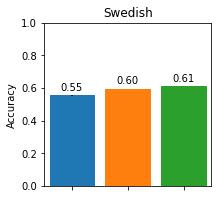

In [28]:
create_barchart("Swedish")
plt.savefig("Figures/figure3-15.png", bbox_inches="tight")

### Figure 4

Sentiment Analysis Task

Comparison of all three pipelines' accuracies for each language, *with* neutrals.

In [29]:
pipelines = ["Pipeline 2:\nTranslated to English", "Pipeline 1:\nCleaned Original Language", "Pipeline 3:\nTranslated Back to Original"]

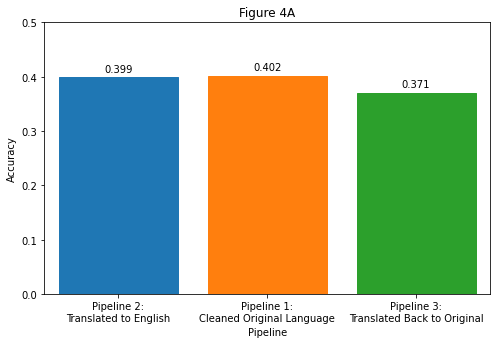

In [30]:
pl1_data = sent_data["Pipeline 1"]["AllTweets"]["Combined"]
pl2_data = sent_data["Pipeline 2"]["AllTweets"]["Combined"]
pl3_data = sent_data["Pipeline 3"]["AllTweets"]["Combined"]
fig_data = pd.DataFrame({"Pipeline": pipelines, 
                     "Median": [pl2_data["Median"], pl1_data["Median"], pl3_data["Median"]],
                     "99 Distance": [pl2_data["99 Distance"], pl1_data["99 Distance"], pl3_data["99 Distance"]]})

plt.rcParams["figure.figsize"] = (8,5)

bp = sns.barplot(
    data=fig_data,
    x="Pipeline",
    y="Median",
    yerr=fig_data["99 Distance"])

plt.ylim(0, 0.5)
bp.set_title("Figure 4A")
bp.set(xlabel="Pipeline", ylabel="Accuracy")

bp.patches[0].set_color("tab:blue")
bp.patches[1].set_color("tab:orange")
bp.patches[2].set_color("tab:green")

for bar in bp.patches:
    bp.annotate(format(bar.get_height(), '.3f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.savefig("Figures/figure4.png", bbox_inches="tight")

In [31]:
fig_data = build_fig34_data("AllTweets")

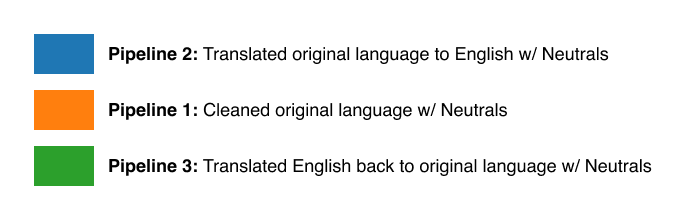

In [32]:
Image(filename="Figures/figure4-legend.png") 

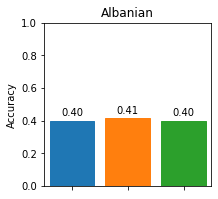

In [33]:
plt.rcParams["figure.figsize"] = (3,3)
create_barchart("Albanian")
plt.savefig("Figures/figure4-1.png", bbox_inches="tight")

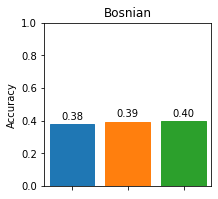

In [34]:
create_barchart("Bosnian")
plt.savefig("Figures/figure4-2.png", bbox_inches="tight")

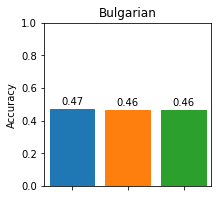

In [35]:
create_barchart("Bulgarian")
plt.savefig("Figures/figure4-3.png", bbox_inches="tight")

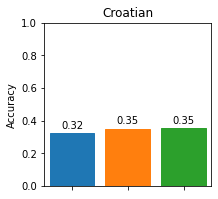

In [36]:
create_barchart("Croatian")
plt.savefig("Figures/figure4-4.png", bbox_inches="tight")

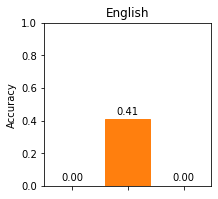

In [37]:
create_barchart("English")
plt.savefig("Figures/figure4-5.png", bbox_inches="tight")

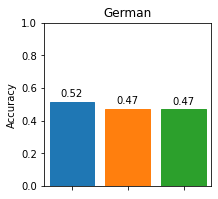

In [38]:
create_barchart("German")
plt.savefig("Figures/figure4-6.png", bbox_inches="tight")

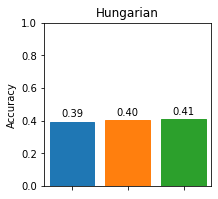

In [39]:
create_barchart("Hungarian")
plt.savefig("Figures/figure4-7.png", bbox_inches="tight")

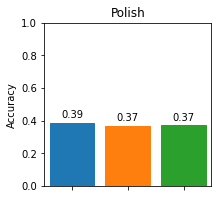

In [40]:
create_barchart("Polish")
plt.savefig("Figures/figure4-8.png", bbox_inches="tight")

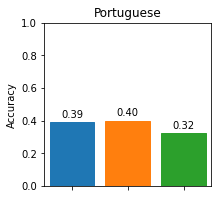

In [41]:
create_barchart("Portuguese")
plt.savefig("Figures/figure4-9.png", bbox_inches="tight")

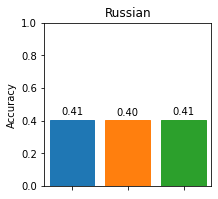

In [42]:
create_barchart("Russian")
plt.savefig("Figures/figure4-10.png", bbox_inches="tight")

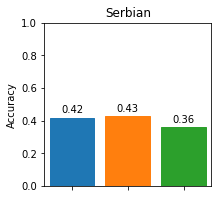

In [43]:
create_barchart("Serbian")
plt.savefig("Figures/figure4-11.png", bbox_inches="tight")

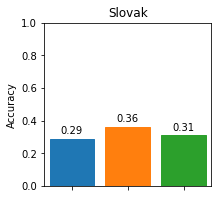

In [44]:
create_barchart("Slovak")
plt.savefig("Figures/figure4-12.png", bbox_inches="tight")

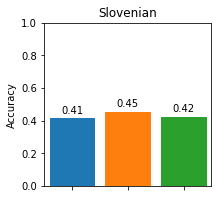

In [45]:
create_barchart("Slovenian")
plt.savefig("Figures/figure4-13.png", bbox_inches="tight")

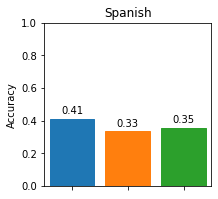

In [46]:
create_barchart("Spanish")
plt.savefig("Figures/figure4-14.png", bbox_inches="tight")

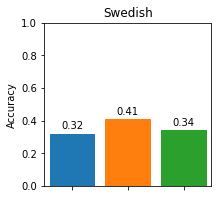

In [47]:
create_barchart("Swedish")
plt.savefig("Figures/figure4-15.png", bbox_inches="tight")

### Figure 5 (Extension)

Topic Clustering Task

No bootstrapping. Lines are the permutation test (chance) accuracy of each language.

Accuracy of Pipeline 3 compared to Pipeline 1.

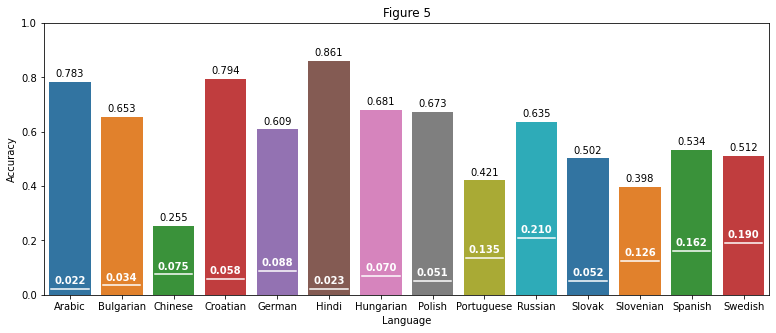

In [95]:
fig_data = pd.DataFrame({"Language": list(cluster_data.keys()), 
                     "Median": [cluster_data[lang]["Accuracy"] for lang in cluster_data],
                     "Perm Test": [cluster_data[lang]["Perm Test"] for lang in cluster_data]})

plt.rcParams["figure.figsize"] = (13,5)

fig, ax = plt.subplots()
bp = sns.barplot(
    data=fig_data,
    x="Language",
    y="Median",
    palette=sns.color_palette("tab10"),
    ax=ax)

plt.ylim(0, 1)
bp.set_title("Figure 5")
bp.set(xlabel="Language", ylabel="Accuracy")

# Generate the horizontal chance lines on each bar
for i in range(len(fig_data)):
    bp.axhline(fig_data["Perm Test"][i], 
               xmin=i / len(fig_data) + 0.01, 
               xmax=(i + 1) / len(fig_data) - 0.01, 
               color="white")

for i, bar in enumerate(bp.patches):
    # Annotate the bar height
    bp.annotate(format(bar.get_height(), '.3f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')
    # Annotate horizontal lines
    bp.annotate(format(fig_data["Perm Test"][i], '.3f'),
                (i, fig_data["Perm Test"][i]), 
                ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points',
                color="white", weight=700)

plt.savefig("Figures/figure5.png", bbox_inches="tight")

### Figure 6 (Extension)

Effect of k on topic clustering accuracy.

Average is the average of the accuracies of each langauge, not the overall accuracy of the datasets if they were combined.

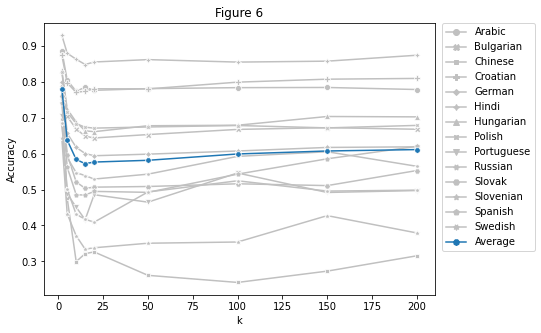

In [12]:
fig_data = pd.DataFrame(k_cluster_data).T
fig_data.index = fig_data.index.astype(int)
fig_data = fig_data.sort_index()

plt.rcParams["figure.figsize"] = (7,5)

palette = {'Arabic': "silver",
  'Bulgarian': "silver",
  'Chinese': "silver",
  'Croatian': "silver",
  'German': "silver",
  'Hindi': "silver",
  'Hungarian': "silver",
  'Polish': "silver",
  'Portuguese': "silver",
  'Russian': "silver",
  'Slovak': "silver",
  'Slovenian': "silver",
  'Spanish': "silver",
  'Swedish': "silver",
  'Average': "tab:blue"}

lp = sns.lineplot(
        data=fig_data,
        markers=True,
        dashes=False,
        palette=palette)

lp.set_title("Figure 6")
lp.set(xlabel="k", ylabel="Accuracy")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.savefig("Figures/figure6.png", bbox_inches="tight")

### Figure 7 (Extension)

Sentiment Analysis Task Extension

Comparison of all three pipelines' accuracies for each language.

In [49]:
def build_fig6_data():
    fig_data = { "Arabic" :   {},
                 "Chinese" :    {},
                 "Hindi" :  {},  }

    for lang in fig_data:
        fig_data[lang]["Medians"] = [sent_data_newlang["Pipeline 2"]["NoNeuTweets"][lang]["Median"],
                                     sent_data_newlang["Pipeline 1"]["NoNeuTweets"][lang]["Median"],
                                     sent_data_newlang["Pipeline 3"]["NoNeuTweets"][lang]["Median"]]
        fig_data[lang]["99 Distances"] = [sent_data_newlang["Pipeline 2"]["NoNeuTweets"][lang]["99 Distance"],
                                          sent_data_newlang["Pipeline 1"]["NoNeuTweets"][lang]["99 Distance"],
                                          sent_data_newlang["Pipeline 3"]["NoNeuTweets"][lang]["99 Distance"]]
    
    return fig_data

In [50]:
fig_data = build_fig6_data()

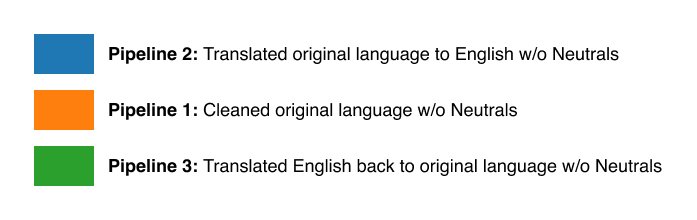

In [51]:
Image(filename="Figures/figure3-legend.png") 

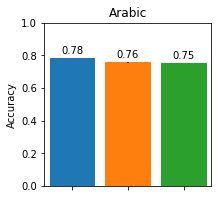

In [52]:
plt.rcParams["figure.figsize"] = (3,3)
create_barchart("Arabic")
plt.savefig("Figures/figure7-1.png", bbox_inches="tight")

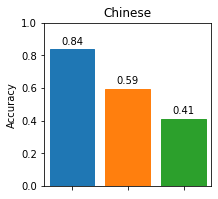

In [53]:
create_barchart("Chinese")
plt.savefig("Figures/figure7-2.png", bbox_inches="tight")

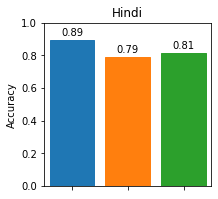

In [54]:
create_barchart("Hindi")
plt.savefig("Figures/figure7-3.png", bbox_inches="tight")

# Increase/Decrease

In [58]:
# Use the same data as Figure 3
# Remember that the data is ordered Pipeline 2, Pipeline 1, Pipeline 3
fig_data = build_fig34_data("NoNeuTweets")

In [59]:
increased = []
decreased = []
for key, val in fig_data.items():
    medians = val["Medians"]
    if key == "English":
        continue
    if medians[1] < medians[2]:
        increased.append((key, medians[2] - medians[1]))
    else:
        decreased.append((key, medians[2] - medians[1]))

print("Increased between Pipeline 1 and Pipeline 3")
print(*increased, sep='\n')
print("Decreased between Pipeline 1 and Pipeline 3")
print(*decreased, sep='\n')

Increased between Pipeline 1 and Pipeline 3
('Bosnian', 0.013271292167222781)
('Bulgarian', 0.0021981981543026663)
('Croatian', 0.004600384537399971)
('German', 0.011051401701178243)
('Hungarian', 0.0016407575526895535)
('Polish', 0.007363821046500574)
('Portuguese', 0.01271990994649752)
('Russian', 0.02443288154260881)
('Slovak', 0.005109338576128941)
('Slovenian', 0.012392265352633491)
('Swedish', 0.015343834059811545)
Decreased between Pipeline 1 and Pipeline 3
('Albanian', -0.012241881871933424)
('Serbian', -0.1566260289494923)
('Spanish', -0.03108267555742361)


In [60]:
increased = []
decreased = []
for key, val in fig_data.items():
    medians = val["Medians"]
    if key == "English":
        continue
    if medians[1] < medians[0]:
        increased.append((key, medians[0] - medians[1]))
    else:
        decreased.append((key, medians[0] - medians[1]))

print("Increased between Pipeline 1 and Pipeline 2")
print(*increased, sep='\n')
print("Decreased between Pipeline 1 and Pipeline 2")
print(*decreased, sep='\n')

Increased between Pipeline 1 and Pipeline 2
('Albanian', 0.03456399475021665)
('Bosnian', 0.04359679633112967)
('Bulgarian', 0.017214984788738508)
('Croatian', 0.06859461546521928)
('German', 0.035946127819261986)
('Hungarian', 0.09609410602940616)
('Polish', 0.0343647748505993)
('Russian', 0.0012553290721923904)
('Slovak', 0.04814319167638392)
('Spanish', 0.2566228056526748)
Decreased between Pipeline 1 and Pipeline 2
('Portuguese', -0.013124766705963076)
('Serbian', -0.1432400641571605)
('Slovenian', -0.14556191374243055)
('Swedish', -0.042515722005163514)


In [61]:
increased = []
decreased = []
for key, val in fig_data.items():
    medians = val["Medians"]
    if key == "English":
        continue
    if medians[0] < medians[2]:
        increased.append((key, medians[2] - medians[0]))
    else:
        decreased.append((key, medians[2] - medians[0]))

print("Increased between Pipeline 2 and Pipeline 3")
print(*increased, sep='\n')
print("Decreased between Pipeline 2 and Pipeline 3")
print(*decreased, sep='\n')

Increased between Pipeline 2 and Pipeline 3
('Portuguese', 0.025844676652460596)
('Russian', 0.023177552470416418)
('Slovenian', 0.15795417909506404)
('Swedish', 0.05785955606497506)
Decreased between Pipeline 2 and Pipeline 3
('Albanian', -0.04680587662215008)
('Bosnian', -0.03032550416390689)
('Bulgarian', -0.015016786634435841)
('Croatian', -0.0639942309278193)
('German', -0.024894726118083743)
('Hungarian', -0.0944533484767166)
('Polish', -0.027000953804098726)
('Serbian', -0.013385964792331784)
('Slovak', -0.04303385310025498)
('Spanish', -0.2877054812100984)
